In [1]:
import pandas as pd
import numpy as np

In [2]:
df_final_features = pd.read_csv('02_Features_final.csv')

In [3]:
df = df_final_features.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# Calculate indices for splitting
total_rows = len(df)
train_end = int(0.7 * total_rows)
test1_end = train_end + int(0.15 * total_rows)

# Perform the split
train_df = df.iloc[:train_end]
test1_df = df.iloc[train_end:test1_end]
test2_df = df.iloc[test1_end:]

In [4]:
Train_selected = pd.read_csv('X_train_selected.csv')

In [5]:
importance1_df=pd.read_csv('feature_importance_model1.csv')

In [6]:
importance2_df=pd.read_csv('feature_importance_model2.csv')

In [7]:
# Combine both importance dataframes
importance1_df['model'] = 'model1'
importance2_df['model'] = 'model2'

combined_importance = pd.concat([importance1_df, importance2_df], axis=0)

# Keep features that have importance > 0.5% in either model
selected_features = combined_importance[combined_importance['importance'] > 0.5]['feature'].unique().tolist()

# Preview selected features
print(f'Number of selected features: {len(selected_features)}')
print(selected_features)

Number of selected features: 17
['P_2Ave3', 'P_2Min3', 'D_39Ave3', 'D_39Max3', 'D_39Max6', 'B_2Ave3', 'R_1Ave3', 'R_1Max3', 'R_1Sum3', 'S_3Ave12', 'B_3Ave3', 'D_43Ave3', 'D_43Ave12', 'B_4Max3', 'B_4Max6', 'D_46Min3', 'P_3Min12']


In [8]:
X_train_nn = train_df[selected_features]
X_test1_nn = test1_df[selected_features]
X_test2_nn = test2_df[selected_features]

In [9]:
# Fill missing values with 0
X_train_nn = X_train_nn.fillna(0)
X_test1_nn = X_test1_nn.fillna(0)
X_test2_nn = X_test2_nn.fillna(0)

In [10]:
# Cap and floor function
def cap_floor(df):
    capped_df = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if capped_df[col].dtype == 'bool':
            capped_df[col] = capped_df[col].astype(int)
        lower = capped_df[col].quantile(0.01)
        upper = capped_df[col].quantile(0.99)
        capped_df[col] = capped_df[col].clip(lower=lower, upper=upper)
    return capped_df
X_train_nn = cap_floor(X_train_nn)
X_test1_nn = cap_floor(X_test1_nn)
X_test2_nn = cap_floor(X_test2_nn)

In [11]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on train, transform all
X_train_nn_scaled = scaler.fit_transform(X_train_nn)
X_test1_nn_scaled = scaler.transform(X_test1_nn)
X_test2_nn_scaled = scaler.transform(X_test2_nn)

In [12]:
# Prepare the target variable
y_train_nn = train_df['target']
y_test1_nn = test1_df['target']
y_test2_nn = test2_df['target']

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import itertools

In [14]:
# Convert data to numpy arrays for TensorFlow
X_train_nn_np = np.array(X_train_nn_scaled)
X_test1_nn_np = np.array(X_test1_nn_scaled)
X_test2_nn_np = np.array(X_test2_nn_scaled)

y_train_nn_np = np.array(y_train_nn)
y_test1_nn_np = np.array(y_test1_nn)
y_test2_nn_np = np.array(y_test2_nn)

In [15]:
def build_nn_model(input_dim, num_layers, num_nodes, activation, dropout_rate):
    model = Sequential()
    
    # Input layer + first hidden layer
    model.add(Dense(num_nodes, input_dim=input_dim, activation=activation))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Add additional hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(num_nodes, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[])
    
    return model

In [16]:
# Hyperparameter options
hidden_layers_options = [2, 4]
nodes_options = [4, 6]
activations_options = ['relu', 'tanh']
dropout_options = [0.5, 0.0]  # 50% and no dropout
batch_size_options = [100, 10000]

# Generate all combinations
param_grid = list(itertools.product(hidden_layers_options, nodes_options, activations_options, dropout_options, batch_size_options))

In [17]:
results_columns = ['Hidden Layers', 'Nodes', 'Activation Function', 'Dropout', 'Batch Size', 'AUC Train', 'AUC Test 1', 'AUC Test 2']
results_df = pd.DataFrame(columns=results_columns)

# File to store intermediate results
results_file = 'nn_grid_search_results.csv'

# If you already have results, load them
try:
    results_df = pd.read_csv(results_file)
    print(f"Loaded existing results with {len(results_df)} rows.")
except FileNotFoundError:
    print("No previous results found. Starting fresh.")

Loaded existing results with 32 rows.


In [18]:
epochs = 20
for params in param_grid:
    num_layers, num_nodes, activation, dropout, batch_size = params
    existing_row = results_df[
        (results_df['Hidden Layers'] == num_layers) &
        (results_df['Nodes'] == num_nodes) &
        (results_df['Activation Function'] == activation) &
        (results_df['Dropout'] == dropout) &
        (results_df['Batch Size'] == batch_size)
    ]
    
    if not existing_row.empty:
        print(f"Skipping already evaluated params: {params}")
        continue
    
    print(f"Training model with Layers={num_layers}, Nodes={num_nodes}, Activation={activation}, Dropout={dropout}, Batch={batch_size}")
    model = build_nn_model(input_dim=X_train_nn_np.shape[1],
                           num_layers=num_layers,
                           num_nodes=num_nodes,
                           activation=activation,
                           dropout_rate=dropout)
    
    model.fit(X_train_nn_np, y_train_nn_np,
              epochs=epochs,
              batch_size=batch_size,
              verbose=0)
    y_train_pred = model.predict(X_train_nn_np).flatten()
    y_test1_pred = model.predict(X_test1_nn_np).flatten()
    y_test2_pred = model.predict(X_test2_nn_np).flatten()

    auc_train = roc_auc_score(y_train_nn_np, y_train_pred)
    auc_test1 = roc_auc_score(y_test1_nn_np, y_test1_pred)
    auc_test2 = roc_auc_score(y_test2_nn_np, y_test2_pred)

    print(f'AUC Train: {auc_train:.4f}, AUC Test 1: {auc_test1:.4f}, AUC Test 2: {auc_test2:.4f}')
    row_df = pd.DataFrame([{
        'Hidden Layers': num_layers,
        'Nodes': num_nodes,
        'Activation Function': activation,
        'Dropout': dropout,
        'Batch Size': batch_size,
        'AUC Train': auc_train,
        'AUC Test 1': auc_test1,
        'AUC Test 2': auc_test2
    }])
    results_df = pd.concat([results_df, row_df], ignore_index=True)
    results_df.to_csv(results_file,index=False)

Skipping already evaluated params: (2, 4, 'relu', 0.5, 100)
Skipping already evaluated params: (2, 4, 'relu', 0.5, 10000)
Skipping already evaluated params: (2, 4, 'relu', 0.0, 100)
Skipping already evaluated params: (2, 4, 'relu', 0.0, 10000)
Skipping already evaluated params: (2, 4, 'tanh', 0.5, 100)
Skipping already evaluated params: (2, 4, 'tanh', 0.5, 10000)
Skipping already evaluated params: (2, 4, 'tanh', 0.0, 100)
Skipping already evaluated params: (2, 4, 'tanh', 0.0, 10000)
Skipping already evaluated params: (2, 6, 'relu', 0.5, 100)
Skipping already evaluated params: (2, 6, 'relu', 0.5, 10000)
Skipping already evaluated params: (2, 6, 'relu', 0.0, 100)
Skipping already evaluated params: (2, 6, 'relu', 0.0, 10000)
Skipping already evaluated params: (2, 6, 'tanh', 0.5, 100)
Skipping already evaluated params: (2, 6, 'tanh', 0.5, 10000)
Skipping already evaluated params: (2, 6, 'tanh', 0.0, 100)
Skipping already evaluated params: (2, 6, 'tanh', 0.0, 10000)
Skipping already evaluat

In [19]:
# Convert data to numpy arrays for TensorFlow
X_train_nn_np = np.array(X_train_nn_scaled)
X_test1_nn_np = np.array(X_test1_nn_scaled)
X_test2_nn_np = np.array(X_test2_nn_scaled)

y_train_nn_np = np.array(y_train_nn)
y_test1_nn_np = np.array(y_test1_nn)
y_test2_nn_np = np.array(y_test2_nn)

In [20]:
# Use the best combination from your grid search
best_layers = 2
best_nodes = 6
best_activation = 'relu'
best_dropout = 0.5
best_batch_size = 100
best_epochs=20

In [21]:
# Reuse your model builder function
final_model = build_nn_model(
    input_dim=X_train_nn_np.shape[1],
    num_layers=best_layers,
    num_nodes=best_nodes,
    activation=best_activation,
    dropout_rate=best_dropout
)

# Train final model on full training data
final_model.fit(
    X_train_nn_np,
    y_train_nn_np,
    epochs=best_epochs,
    batch_size=best_batch_size,
verbose=1
)

Epoch 1/20


c:\Users\shrey\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 0.6350
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - loss: 0.3927
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 0.3776
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3665
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3696  
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3663  
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 0.3619
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.3688
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 0.3591
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - loss: 0.3614
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - loss: 0.3588
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - loss: 0.3645
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 0.3627
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - loss: 0.3608
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1

In [22]:
from sklearn.metrics import roc_auc_score

# Predict
y_train_pred = final_model.predict(X_train_nn_np).flatten()
y_test1_pred = final_model.predict(X_test1_nn_np).flatten()
y_test2_pred = final_model.predict(X_test2_nn_np).flatten()

# AUC scores
print("Final AUC Train:", roc_auc_score(y_train_nn_np, y_train_pred))
print("Final AUC Test 1:", roc_auc_score(y_test1_nn_np, y_test1_pred))
print("Final AUC Test 2:", roc_auc_score(y_test2_nn_np,y_test2_pred))

2008/2008 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
Final AUC Train: 0.9434703104787896
Final AUC Test 1: 0.94523360673171
Final AUC Test 2: 0.9417201451059516


In [23]:
# Save the model in a folder (will create it)
final_model.save('final_nn_model.keras')

In [24]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('final_nn_model.keras')

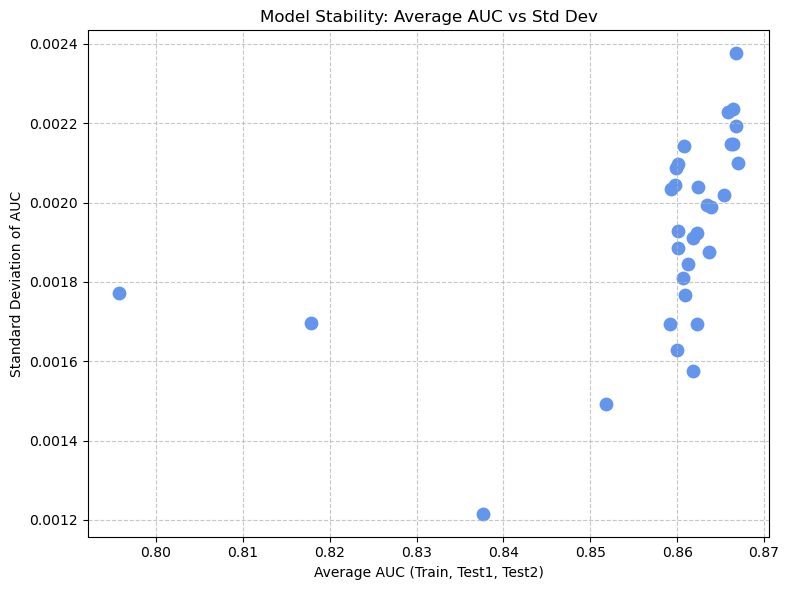

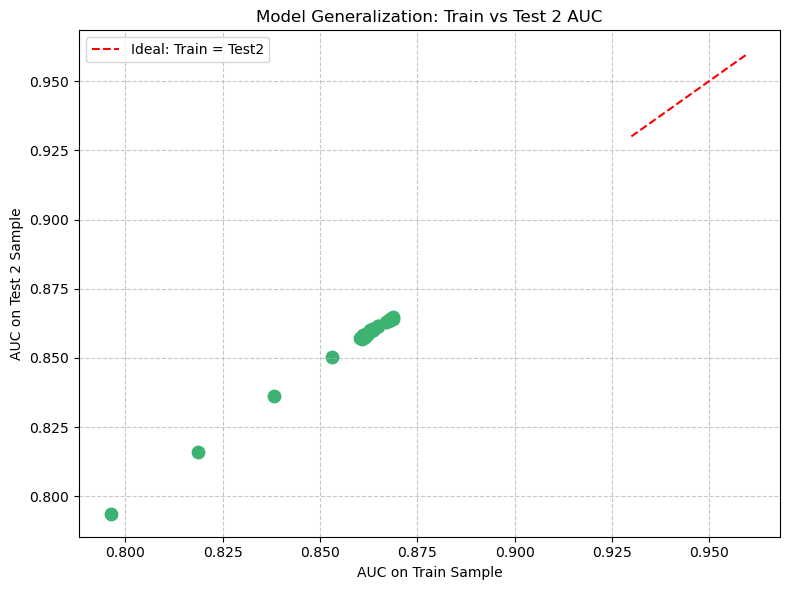

In [25]:
import matplotlib.pyplot as plt

# Calculate average and std dev of AUC across Train, Test1, and Test2
results_df['AUC Avg'] = results_df[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
results_df['AUC Std'] = results_df[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)

# === Scatter Plot 1: Average AUC vs Standard Deviation ===
plt.figure(figsize=(8, 6))
plt.scatter(results_df['AUC Avg'], results_df['AUC Std'], color='cornflowerblue', s=80)
plt.xlabel("Average AUC (Train, Test1, Test2)")
plt.ylabel("Standard Deviation of AUC")
plt.title("Model Stability: Average AUC vs Std Dev")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Scatter Plot 2: Train AUC vs Test2 AUC ===
plt.figure(figsize=(8, 6))
plt.scatter(results_df['AUC Train'], results_df['AUC Test 2'], color='mediumseagreen', s=80)
plt.plot([0.93, 0.96], [0.93, 0.96], 'r--', label='Ideal: Train = Test2')
plt.xlabel("AUC on Train Sample")
plt.ylabel("AUC on Test 2 Sample")
plt.title("Model Generalization: Train vs Test 2 AUC")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


2008/2008 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
Best Model Parameters:
Model Number       : 3
# Hidden Layers     : 2
# Nodes             : 4
Dropout             : 0.0
Batch Size          : 100
AUC Train           : 0.943470
AUC Test 1          : 0.945234
AUC Test 2          : 0.941720
Mean AUC (Test)     : 0.943477
Std AUC (Test)      : 0.001757
AUC Diff (Train - Test): 0.000007


C:\Users\shrey\AppData\Local\Temp\ipykernel_17448\124992976.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('bin')['default'].mean()


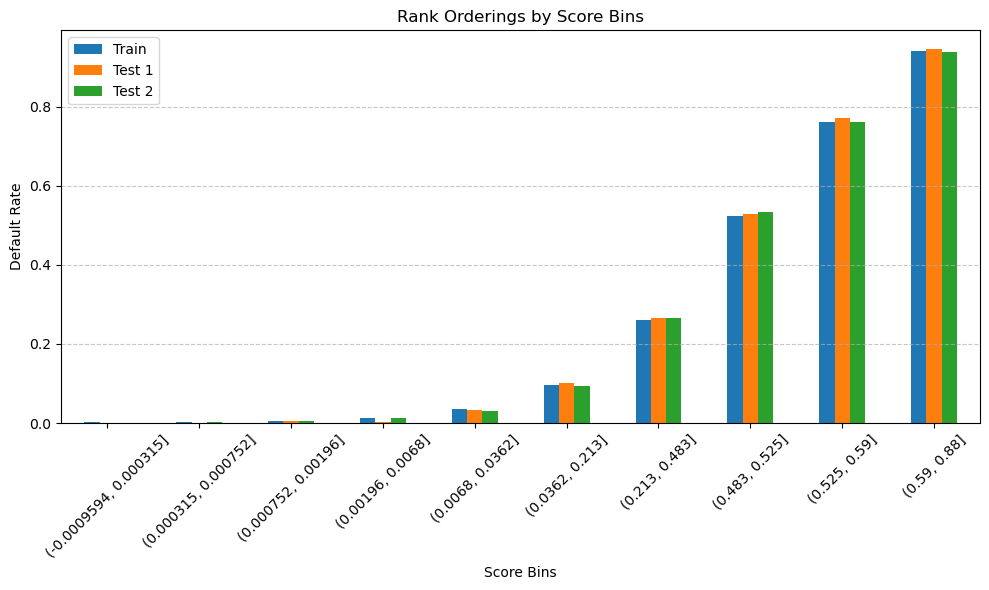

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --- Predict using your final selected model ---
y_train_pred = final_model.predict(X_train_nn_np).flatten()
y_test1_pred = final_model.predict(X_test1_nn_np).flatten()
y_test2_pred = final_model.predict(X_test2_nn_np).flatten()

# --- AUC Scores ---
auc_train = roc_auc_score(y_train_nn_np, y_train_pred)
auc_test1 = roc_auc_score(y_test1_nn_np, y_test1_pred)
auc_test2 = roc_auc_score(y_test2_nn_np, y_test2_pred)
auc_test_mean = np.mean([auc_test1, auc_test2])
auc_test_std = np.std([auc_test1, auc_test2])
auc_diff = abs(auc_train - auc_test_mean)

# --- Manually enter final model parameters (based on selection) ---
model_number = 3
num_layers = 2
num_nodes = 4
dropout_rate = 0.0
batch_size = 100

# --- Print Final Model Summary ---
print("Best Model Parameters:")
print("Model Number       :", model_number)
print("# Hidden Layers     :", num_layers)
print("# Nodes             :", num_nodes)
print("Dropout             :", dropout_rate)
print("Batch Size          :", batch_size)
print(f"AUC Train           : {auc_train:.6f}")
print(f"AUC Test 1          : {auc_test1:.6f}")
print(f"AUC Test 2          : {auc_test2:.6f}")
print(f"Mean AUC (Test)     : {auc_test_mean:.6f}")
print(f"Std AUC (Test)      : {auc_test_std:.6f}")
print(f"AUC Diff (Train - Test): {auc_diff:.6f}")

# --- Rank Ordering by Score Bins ---
# Define score bins using training predictions (deciles)
bin_edges = np.quantile(y_train_pred, np.linspace(0, 1, 11))

# Function to calculate default rate per bin
def default_rate_by_bin(y_true, y_pred, bins):
    bin_labels = pd.cut(y_pred, bins=bins, include_lowest=True)
    df = pd.DataFrame({'bin': bin_labels, 'default': y_true})
    return df.groupby('bin')['default'].mean()

# Compute default rates in each bin
train_bins = default_rate_by_bin(y_train_nn_np, y_train_pred, bin_edges)
test1_bins = default_rate_by_bin(y_test1_nn_np, y_test1_pred, bin_edges)
test2_bins = default_rate_by_bin(y_test2_nn_np, y_test2_pred, bin_edges)

# Combine into one DataFrame for plotting
rank_df = pd.DataFrame({
    'Train': train_bins,
    'Test 1': test1_bins,
    'Test 2': test2_bins
})

# --- Plot Rank Ordering ---
rank_df.plot(kind='bar', figsize=(10, 6))
plt.title("Rank Orderings by Score Bins")
plt.xlabel("Score Bins")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
